# XGBoost Model

## Importing libraries

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Importing the dataset

In [ ]:
my_ds = pd.read_csv('breast-cancer.csv')
x = my_ds.iloc[:, 2:]
y = my_ds.iloc[:, 1].values

## Droping cols with tiny impact on dependent variable

In [ ]:
x = x.drop(['smoothness_se','texture_se', 'symmetry_se', 'fractal_dimension_mean', 'fractal_dimension_se'], axis=1)

In [ ]:
x = x.values

# Encoding Dependent Variable

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Splitting the dataset into the training set and the test set

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Training XGBoost on training set

## Found Optimal parameters

In [ ]:
from xgboost import XGBClassifier as xgbc
from sklearn.model_selection import GridSearchCV
from numpy import arange


classifier = xgbc()
parameters = [ {
    'n_estimators': list(range(10, 201, 1)),
    'learning_rate': arange(0.01, 0.5, 0.01),
    'gamma': arange(0, 1, 0.02),
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'random_state' : [0]
} ]

grid_search = GridSearchCV(
    estimator = classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(x_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.10f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 98.4685990338 %
Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0.16, 'learning_rate': 0.27, 'max_depth': 2, 'n_estimators': 157, 'random_state': 0, 'subsample': 0.5}


## Train classifier by optimal parameters

In [ ]:
new_classifier = xgbc(**best_parameters)
new_classifier.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.16, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=157, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

# SHAP

**Expainer**

In [ ]:
# Fits the explainer
explainer = shap.Explainer(new_classifier.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

**Bar Plot**

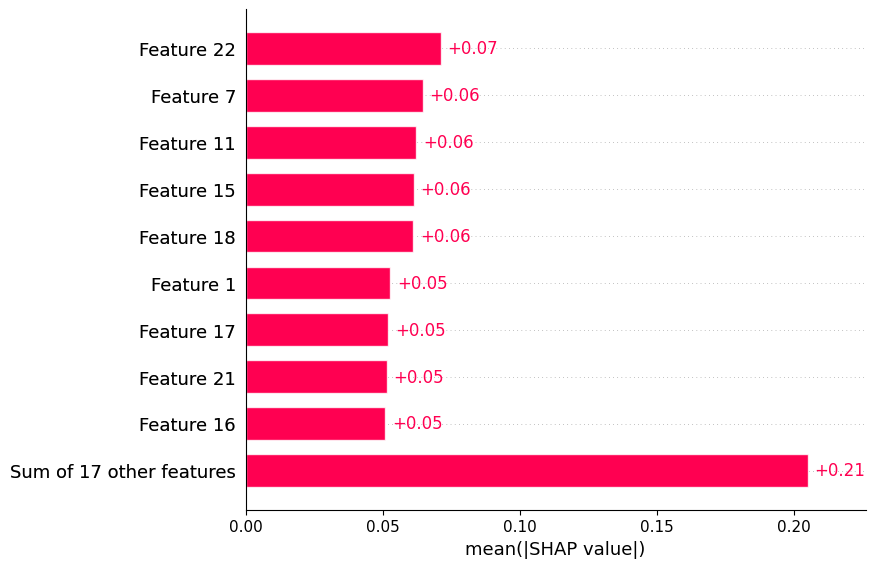

In [ ]:
shap.plots.bar(shap_values)

**Summary Plot**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


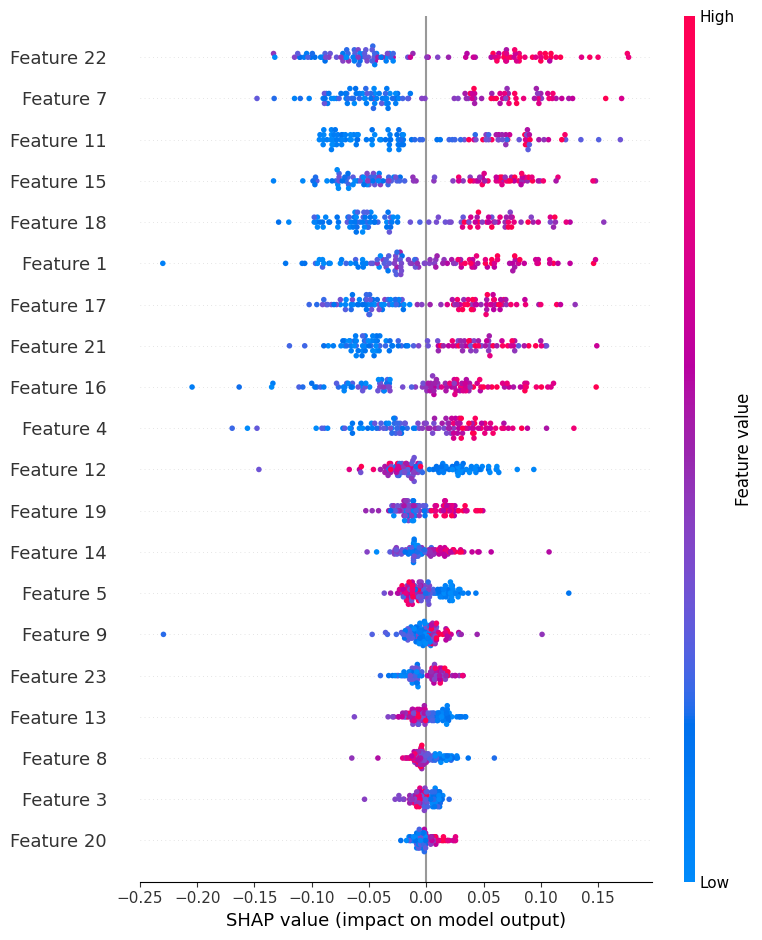

In [ ]:
shap.summary_plot(shap_values)

**Summary Plot Violin**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


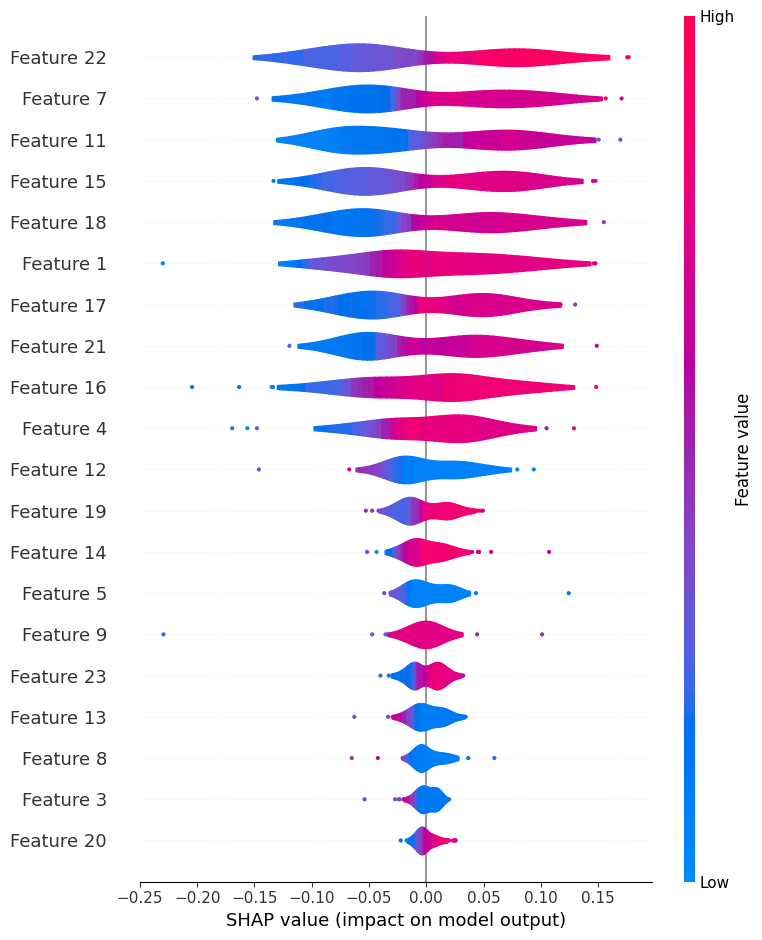

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')

**Local Bar Plot**

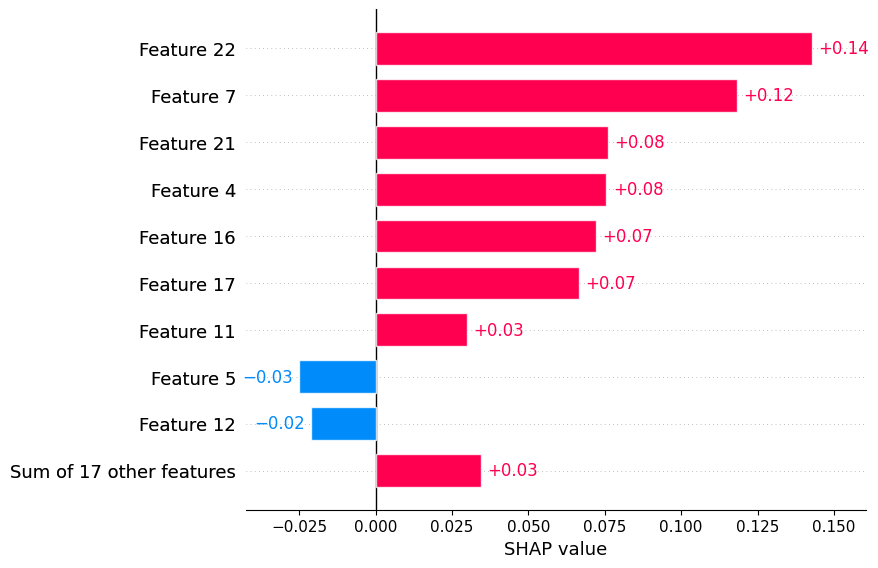

In [ ]:
shap.plots.bar(shap_values[0])

# Applying k-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=new_classifier, X=x_train, y=y_train, cv=10)

In [ ]:
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 98.47 %
Standard Deviation: 1.40 %


# Confusion Matrix & accuracy score


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = new_classifier.predict(x_test)

my_conf_matrix2 = confusion_matrix(y_test, y_pred)
print(my_conf_matrix2)
accuracy_score(y_test, y_pred)

[[66  1]
 [ 1 46]]


0.9824561403508771

### Confusion Martix with labels

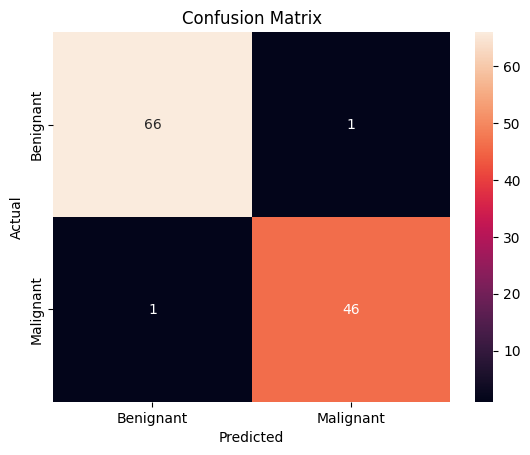

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(my_conf_matrix2, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Benignant', 'Malignant']); ax.yaxis.set_ticklabels(['Benignant', 'Malignant']);

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        67
           1       0.98      0.98      0.98        47

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Specificity & Sensitivity Score

In [ ]:
from imblearn.metrics import sensitivity_specificity_support

pd.DataFrame(sensitivity_specificity_support(y_test, y_pred, average=None), index=['Sensitivity', 'Specificity', 'Support']).T

,Sensitivity,Specificity,Support
0,0.985075,0.978723,67.0
1,0.978723,0.985075,47.0


## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = new_classifier.predict_proba(x_test)

In [ ]:
pd.DataFrame(y_pred_proba)

,0,1
0,0.000395,0.999605
1,0.977011,0.022989
2,0.999969,0.000031
3,0.998685,0.001315
4,0.999807,0.000193
...,...,...
109,0.000313,0.999687
110,0.999693,0.000307
111,0.000161,0.999839
112,0.000319,0.999681


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


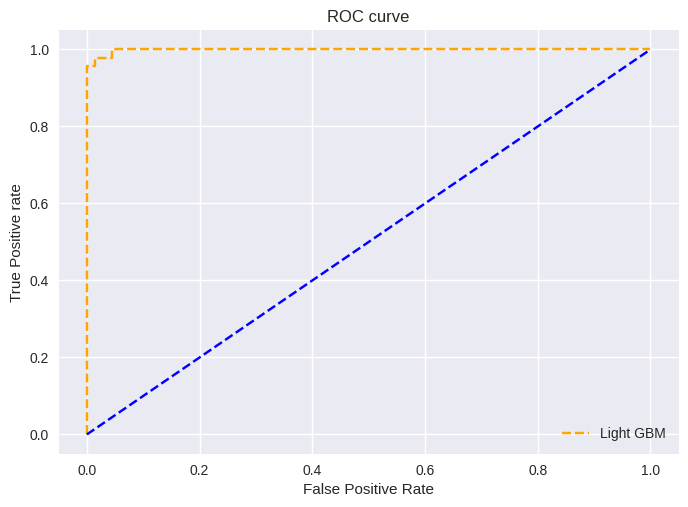

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Light GBM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_proba[:,1]))

ROC AUC Score:  0.9987297554779295


## Precision Recall Curve (PRC)

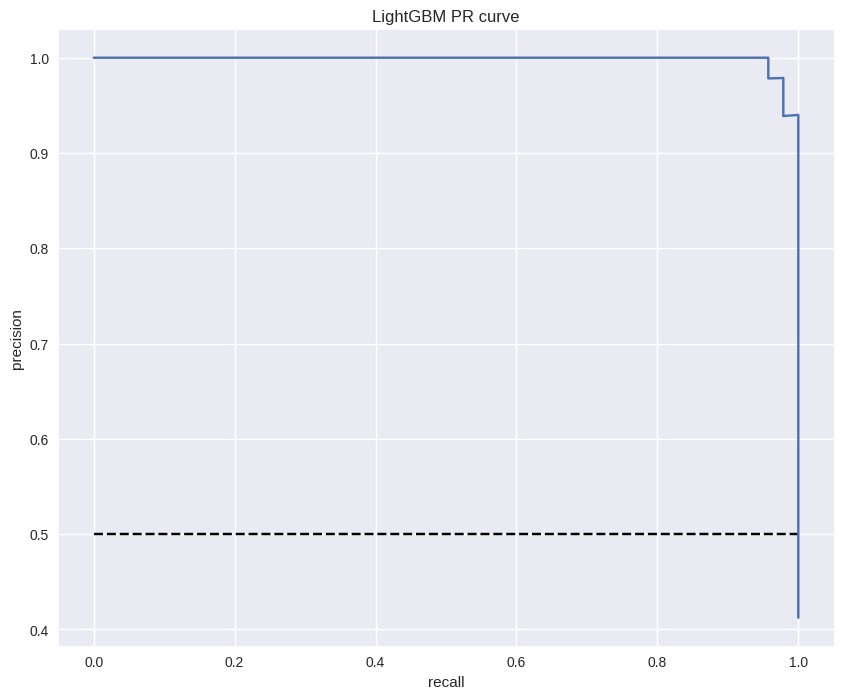

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5, 0.5],'k--')
plt.plot(recall, precision, label = 'Knn')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('LightGBM PR curve')
plt.show()

In [ ]:
print("PRC AUC Score: ", auc(recall, precision))

PRC AUC Score:  0.9982527636598363
